In [3]:
import os
import gc
import sys
import time
import h5py
import numpy as np
import pandas as pd
from numpy.lib.function_base import corrcoef
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
print('read the tractogram data(group)...')
reg = sps.load_npz('/n02dat01/users/yfwang/dyli/group_SC/reg_L.npz')
reg = reg.toarray().astype(np.float32)
print(reg.shape)
print('finished!')

read the tractogram data(group)...


In [ ]:
mpc = np.loadtxt('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_L.txt')

In [2]:
_1 = pd.read_csv('/n02dat01/users/dyli/HCP_behavior_data/HCP_s1200.csv') # Subject
_2 = pd.read_csv('/n02dat01/users/dyli/HCP_behavior_data/RESTRICTED_s1200_calculated.csv')
basic_info = pd.merge(_1, _2, left_on = 'Subject', right_on = 'Subject').loc[:,['Subject', 'Gender', 'Age_in_Yrs', 'Handedness', 'Race']]
basic_info

,Subject,Gender,Age_in_Yrs,Handedness,Race
0,100004,M,24,95,White
1,100206,M,27,65,White
2,100307,F,27,95,White
3,100408,M,33,55,White
4,100610,M,27,85,White
...,...,...,...,...,...
1201,992774,M,35,100,White
1202,993675,F,29,85,White
1203,994273,M,30,60,White
1204,995174,M,25,100,White


In [17]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

namelist_df = pd.DataFrame(namelist, columns=['Subject'], dtype=np.int32)
namelist_basic_info = pd.merge(namelist_df, basic_info, left_on='Subject', right_on='Subject')
namelist_basic_info

100


,Subject,Gender,Age_in_Yrs,Handedness,Race
0,100307,F,27,95,White
1,100408,M,33,55,White
2,101107,M,22,5,White
3,101309,M,29,45,Black or African Am.
4,101915,F,35,-75,White
...,...,...,...,...,...
95,756055,M,25,-80,Black or African Am.
96,792564,F,31,90,White
97,856766,F,33,80,White
98,857263,M,22,-100,Black or African Am.


In [18]:
np.save('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_age.npy', np.array(namelist_basic_info['Age_in_Yrs']))

In [23]:
gender_list = list(namelist_basic_info['Gender'])
gender_array = []
for _ in range(100):
    if gender_list[_]=='F': gender_array.append(2)
    else: gender_array.append(1)
print(np.array(gender_array))
np.save('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_gender.npy', np.array(gender_array))

[2 1 1 1 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 1 2 2 1 1 2 1 1 1 2 2 2 2 2 1 2 2 1
 1 2 2 2 2 1 2 2 1 1 2 2 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 1 2 2 1 2 1 2 1 2 2
 2 1 1 1 2 1 1 2 1 2 2 2 2 2 1 1 1 2 2 1 1 1 2 2 1 2]


In [ ]:
# import statsmodels.api as sm
# import scipy.stats as st
# import sklearn

# for sub in namelist:
#     mpc_sub = h5py.File(f'/n02dat01/users/dyli/Grad_data/sc/SC_MPC_U100/{sub}_L_MPC.mat')

# for tt in range(y_data.shape[1]):
#     y = y_data[:, tt] # (2067, )
#     x = basic_data # (2067, 2)

#     model = sklearn.linear_model.LinearRegression()
#     y[np.isnan(y)] = 0
#     model.fit(x, y)
#     y_pred = model.predict(x)
#     y_data_reg[:, tt] = y - y_pred

# gender

In [8]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

gender_info = np.load('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_gender.npy')

mpc_female = np.zeros((29696, 29696)).astype(np.float32)
mpc_male = np.zeros((29696, 29696)).astype(np.float32)

for subi, sub in tqdm(enumerate(namelist)):
    mpc_ = h5py.File(f'/n02dat01/users/dyli/Grad_data/sc/SC_MPC_U100/{sub}_L_MPC.mat')
    mpc_sub = mpc_['MPCi']
    if gender_info[subi] == 2:
        mpc_female = mpc_female + mpc_sub
    elif gender_info[subi] ==1:
        mpc_male = mpc_male + mpc_sub

np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_female.npy', mpc_female/len(np.argwhere(gender_info==2)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_male.npy', mpc_male/len(np.argwhere(gender_info==1)))

100


100it [3:27:35, 124.56s/it]


In [9]:
r = np.corrcoef(mpc_female.flatten(), mpc_male.flatten())

In [11]:
r

array([[1.       , 0.9945354],
       [0.9945354, 1.       ]])

# age

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


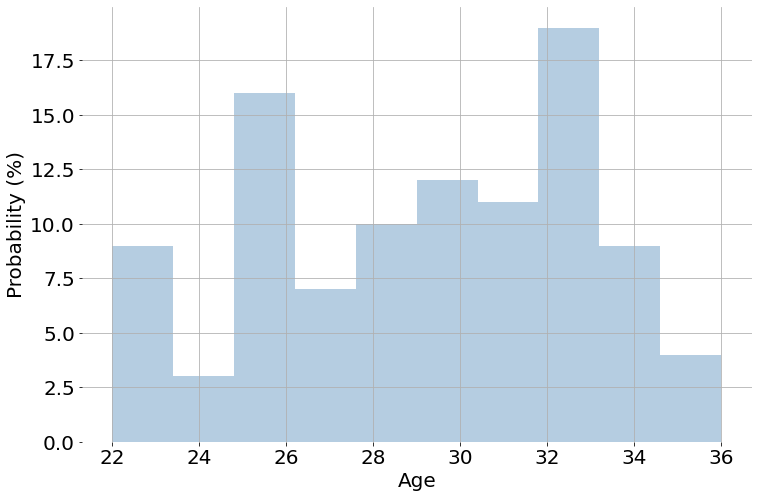

In [15]:
import seaborn as sns

age_info = np.load('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_age.npy')

plt.figure(figsize=(12, 8))  #设置画布的大小
# sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(age_info,color="steelblue",bins=10,norm_hist=False, kde=False)
# plt.xlim([10,1200])
plt.xlabel('Age',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability (%)',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

In [6]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

age_info = np.load('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_age.npy')

x1 = len(np.argwhere(age_info<25.5))
x2 = (len(np.argwhere(age_info<25.5))) - len(np.argwhere(age_info<30.5))
x3 = (len(np.argwhere(age_info<30.5))) - len(np.argwhere(age_info<35.5))
x4 = (len(np.argwhere(age_info<35.5))) - len(np.argwhere(age_info<40))
print(x1, x2, x3, x4)

100
17 -40 -42 -1


In [6]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

age_info = np.load('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_age.npy')

mpc_1 = np.zeros((29696, 29696)).astype(np.float32) # (20, 25)
mpc_2 = np.zeros((29696, 29696)).astype(np.float32) # (25, 30)
mpc_3 = np.zeros((29696, 29696)).astype(np.float32) # (30, 35)
mpc_4 = np.zeros((29696, 29696)).astype(np.float32) # (35, 40)

for subi, sub in tqdm(enumerate(namelist)):
    mpc_ = h5py.File(f'/n02dat01/users/dyli/Grad_data/sc/SC_MPC_U100/{sub}_L_MPC.mat')
    mpc_sub = mpc_['MPCi']
    if age_info[subi]<25:
        mpc_1 = mpc_1 + mpc_sub
    elif age_info[subi]<30:
        mpc_2 = mpc_2 + mpc_sub
    elif age_info[subi]<35:
        mpc_3 = mpc_3 + mpc_sub
    elif age_info[subi]<40:
        mpc_4 = mpc_4 + mpc_sub
    else:
        sys.exit()

np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_1.npy', mpc_1/len(np.argwhere(age_info<25)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_2.npy', mpc_2/(len(np.argwhere(age_info<25))) - len(np.argwhere(age_info<30)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_3.npy', mpc_3/(len(np.argwhere(age_info<30))) - len(np.argwhere(age_info<35)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_4.npy', mpc_4/(len(np.argwhere(age_info<35))) - len(np.argwhere(age_info<40)))

100


100it [3:23:43, 122.24s/it]


In [21]:
mpc_1 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_1.npy')
mpc_2 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_2.npy')
mpc_3 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_agebin_3.npy')

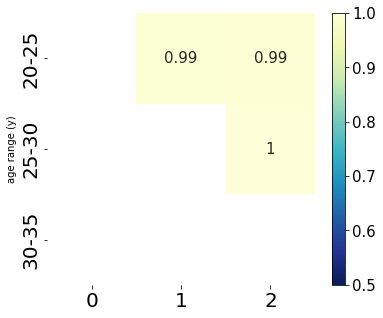

In [22]:
import seaborn as sns

# left
results = np.zeros((3,3))
results[0,1] = np.corrcoef(mpc_1.flatten(), mpc_2.flatten())[0,1]
results[0,2] = np.corrcoef(mpc_1.flatten(), mpc_3.flatten())[0,1]
results[1,2] = np.corrcoef(mpc_2.flatten(), mpc_3.flatten())[0,1]

results[results==0] = np.nan
df = pd.DataFrame(results, index=['20-25','25-30','30-35'])

f, ax= plt.subplots(figsize = (6, 5))
fig = sns.heatmap(df, 
                  cmap='YlGnBu_r', 
                  vmin=0.5, 
                  vmax=1, 
                  cbar=False, 
                  annot=True, 
                  annot_kws={'size':15})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('age range (y)')
plt.show()

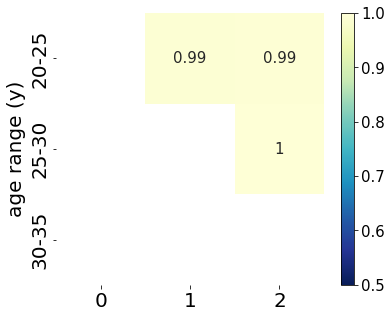

In [23]:
f, ax= plt.subplots(figsize = (6, 5))
fig = sns.heatmap(df, 
                  cmap='YlGnBu_r', 
                  vmin=0.5, 
                  vmax=1, 
                  cbar=False, 
                  annot=True, 
                  annot_kws={'size':15})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('age range (y)', fontsize=20)
plt.show()

# eTIV

1973702.153344 1083055.083886


/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


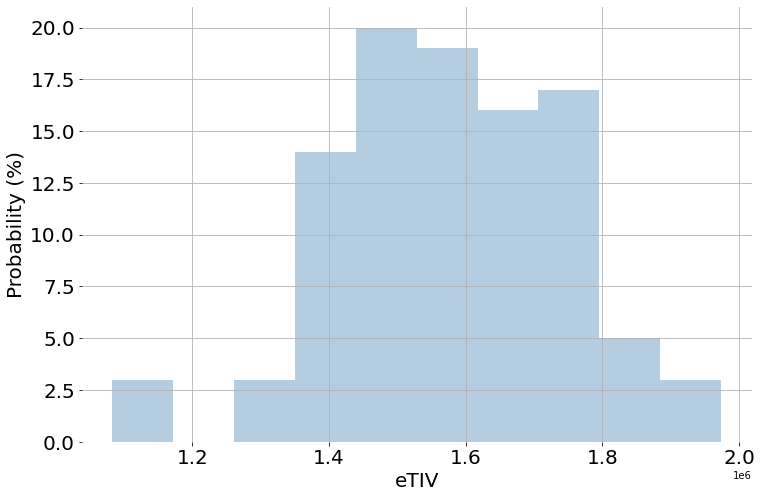

In [9]:
etiv_info = np.loadtxt('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_eTIV.txt')
print(np.max(etiv_info), np.min(etiv_info))

plt.figure(figsize=(12, 8))  #设置画布的大小
# sns.set_palette("hls")       #设置所有图的颜色，使用hls色彩空间
sns.distplot(etiv_info,color="steelblue",bins=10,norm_hist=False, kde=False)
# plt.xlim([10,1200])
plt.xlabel('eTIV',fontsize=20)           #添加x轴标签，并改变字体
plt.ylabel('Probability (%)',fontsize=20)   #添加y轴变浅，并改变字体
plt.grid(linestyle='-')   #添加网格线
plt.xticks(fontsize=20)   #改变x轴字体大小
plt.yticks(fontsize=20)   #改变y轴字体大小
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    #将图像的框框删掉
plt.show()

In [8]:
etiv_info = np.loadtxt('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_eTIV.txt')/1e6
print(np.max(etiv_info), np.min(etiv_info))

x1 = len(np.argwhere(etiv_info<1.2))
x2 = (len(np.argwhere(etiv_info<1.4))) - len(np.argwhere(etiv_info<1.2))
x3 = (len(np.argwhere(etiv_info<1.6))) - len(np.argwhere(etiv_info<1.4))
x4 = (len(np.argwhere(etiv_info<1.8))) - len(np.argwhere(etiv_info<1.6))
x5 = (len(np.argwhere(etiv_info<2.0))) - len(np.argwhere(etiv_info<1.8))
print(x1,x2,x3,x4,x5)

1.973702153344 1.083055083886
3 12 38 40 7


In [2]:
list_path = f'/n02dat01/users/dyli/Grad_data/support_data/HCP_U100_list.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(len(namelist))

etiv_info = np.loadtxt('/n02dat01/users/dyli/HCP_behavior_data/HCP_U100_eTIV.txt')/1e6

mpc_1 = np.zeros((29696, 29696)).astype(np.float32) # (1.0, 1.2)
mpc_2 = np.zeros((29696, 29696)).astype(np.float32) # (1.2, 1.4)
mpc_3 = np.zeros((29696, 29696)).astype(np.float32) # (1.4, 1.6)
mpc_4 = np.zeros((29696, 29696)).astype(np.float32) # (1.6, 1.8)
mpc_5 = np.zeros((29696, 29696)).astype(np.float32) # (1.8, 2.0)

for subi, sub in tqdm(enumerate(namelist)):
    mpc_ = h5py.File(f'/n02dat01/users/dyli/Grad_data/sc/SC_MPC_U100/{sub}_L_MPC.mat')
    mpc_sub = mpc_['MPCi']
    if etiv_info[subi]<1.2:
        mpc_1 = mpc_1 + mpc_sub
    elif etiv_info[subi]<1.4:
        mpc_2 = mpc_2 + mpc_sub
    elif etiv_info[subi]<1.6:
        mpc_3 = mpc_3 + mpc_sub
    elif etiv_info[subi]<1.8:
        mpc_4 = mpc_4 + mpc_sub
    elif etiv_info[subi]<2.0:
        mpc_5 = mpc_5 + mpc_sub
    else:
        sys.exit()

np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_1.npy', mpc_1/len(np.argwhere(etiv_info<1.2)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_2.npy', mpc_2/(len(np.argwhere(etiv_info<1.4))) - len(np.argwhere(etiv_info<1.2)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_3.npy', mpc_3/(len(np.argwhere(etiv_info<1.6))) - len(np.argwhere(etiv_info<1.4)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_4.npy', mpc_4/(len(np.argwhere(etiv_info<1.8))) - len(np.argwhere(etiv_info<1.6)))
np.save('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_5.npy', mpc_5/(len(np.argwhere(etiv_info<2.0))) - len(np.argwhere(etiv_info<1.8)))

100


100it [3:24:09, 122.50s/it]


In [16]:
mpc_1 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_1.npy')
mpc_2 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_2.npy')
mpc_3 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_3.npy')
mpc_4 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_4.npy')
mpc_5 = np.load('/n02dat01/users/dyli/Grad_data/sc/HCP_U100_mpc_5.npy')

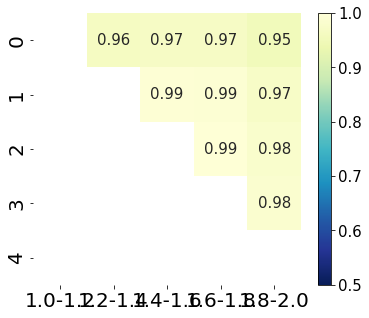

In [17]:
import seaborn as sns

# mpc_1[np.isnan(mpc_1)]=0
# mpc_2[np.isnan(mpc_2)]=0
# mpc_3[np.isnan(mpc_3)]=0
# mpc_4[np.isnan(mpc_4)]=0
# mpc_5[np.isnan(mpc_5)]=0

# left
results = np.zeros((5,5))
results[0,1] = np.corrcoef(mpc_1.flatten(), mpc_2.flatten())[0,1]
results[0,2] = np.corrcoef(mpc_1.flatten(), mpc_3.flatten())[0,1]
results[0,3] = np.corrcoef(mpc_1.flatten(), mpc_4.flatten())[0,1]
results[0,4] = np.corrcoef(mpc_1.flatten(), mpc_5.flatten())[0,1]
results[1,2] = np.corrcoef(mpc_2.flatten(), mpc_3.flatten())[0,1]
results[1,3] = np.corrcoef(mpc_2.flatten(), mpc_4.flatten())[0,1]
results[1,4] = np.corrcoef(mpc_2.flatten(), mpc_5.flatten())[0,1]
results[2,3] = np.corrcoef(mpc_3.flatten(), mpc_4.flatten())[0,1]
results[2,4] = np.corrcoef(mpc_3.flatten(), mpc_5.flatten())[0,1]
results[3,4] = np.corrcoef(mpc_4.flatten(), mpc_5.flatten())[0,1]

results[results==0] = np.nan
df = pd.DataFrame(results, columns=['1.0-1.2', '1.2-1.4', '1.4-1.6', '1.6-1.8', '1.8-2.0'])

f, ax= plt.subplots(figsize = (6, 5))
fig = sns.heatmap(df, 
                  cmap='YlGnBu_r', 
                  vmin=0.5, 
                  vmax=1, 
                  cbar=False, 
                  annot=True, 
                  annot_kws={'size':15})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

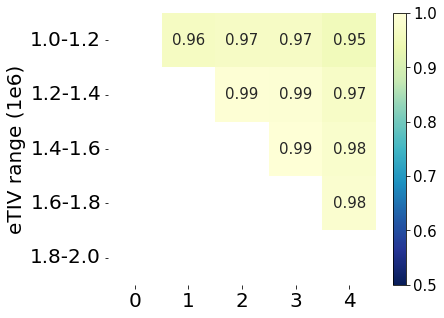

In [20]:
results[results==0] = np.nan
df = pd.DataFrame(results, index=['1.0-1.2', '1.2-1.4', '1.4-1.6', '1.6-1.8', '1.8-2.0'])

f, ax= plt.subplots(figsize = (6, 5))
fig = sns.heatmap(df, 
                  cmap='YlGnBu_r', 
                  vmin=0.5, 
                  vmax=1, 
                  cbar=False, 
                  annot=True, 
                  annot_kws={'size':15})
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=15) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=0)
plt.ylabel('eTIV range (1e6)', fontsize=20)
plt.show()